# Deep Neural Network training to retrieve Normalized-Gamma Size Distribution (NGSD) parameters

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aladinor/Ladino_et_al_2024_DNN_PSD_retrieval/blob/main/notebooks/3.PSD_DNN_Training.ipynb
)

Sets up the environment and data path based on whether the notebook is running in Colab or locally.

In [2]:
if 'google.colab' in str(get_ipython()):
    !wget https://raw.githubusercontent.com/aladinor/Ladino_et_al_2025_DNN_PSD_retrieval/main/scripts/colab_setup.py -O colab_setup.py
    %run colab_setup.py
    path = '/content/Ladino_et_al_2025_DNN_PSD_retrieval/'
else:
    print("Running notebook locally")
    path = '..'

Running notebook locally


## Imports

In [3]:
import xarray as xr
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

2025-03-24 14:22:50.742889: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 14:22:50.910868: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 14:22:50.959139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 14:22:51.036480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 14:22:51.051834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 14:22:51.143083: I tensorflow/core/platform/cpu_feature_gu

In [4]:
# setting up the Seaborne style including figure  dpi
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")

### Local Cluster

Let's spin up our `Dask` local cluster

In [5]:
cluster = LocalCluster()  
# display(cluster)

## Data
Results from [K-means cluster](1.K-means-psd.ipynb)  analysis are loaded into a `Pandas.Dataframe`

In [6]:
df = pd.read_parquet(
    f'{path}/data/df_cluster.parquet'
)

## Deep Neural Network Training

Our feed-forward Deep Neural Network (DNN) was designed to predict the Normalized Gamma Size Distribution (NGSD) parameters ($D_m$, $N_w$, $\mu_{unc}$). After testing different inputs and following previous studies (e.g. [Chase et al., 2021](https://journals.ametsoc.org/view/journals/apme/60/3/JAMC-D-20-0177.1.xml)) we found out that the best results were achieved when using the reflectivity at Ku-Band ($Z_{Ku}$), dual frequency ration ($DFR$), ambient temperature ($T$) and the specific attenuation at Ka-band ($K_{Ka}$) as shown in the following image.

<img src=f"{path}/images/DNN.svg" width=500 alt="DNN" align="center" style="margin:auto"></img>  


Data for training and testing is copied into `X` variable. `Y` variable is use for data labeling and targeting

In [7]:
X = df[['dbz_t_ku', 'dfr', 'Att_ka', 'log10_nw', 'dm', 'mu_unc']]
Y = df[['dm_class', 'r', 'kmeans', 'time']]

Let's transform our input parameters by removing the mean and scaling to unit variance using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from the `Sklearn` Python package as follows

In [8]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'mu_unc']])

Data is splitted into `X_train` and `X_test` as follows

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=40, stratify=df.kmeans)
X_train.shape

(6321, 6)

Now, we define a function that represents our DNN in [Tensorflow](https://www.tensorflow.org/) using the following parameters and hyperparameters

| Parameter/hyperparameters |  |
| --- | --- |
| Hidden layers | 6 |
| Neurons per layer  | 16 |
| Activation function  | Rectify linear units (RELU) |
| Learning rate | 0.001  |
| Max epochs | 500 |
| Optimizer  | Adamax |
| Batch size  | 128 |
| Loss function  | Mean Absolute Error |
| Training/Test dataset (%)   | 80 - 20 |
| Number of inputs - outputs   | 3 - 3 |

In [10]:
def build_model():
    model = tf.keras.models.Sequential() # model instantiation
    model.add(tf.keras.Input(shape=(3,))) # input layer
    model.add(tf.keras.layers.Dense(16, activation="relu")) #-|
    model.add(tf.keras.layers.Dense(16, activation="relu")) #-|
    model.add(tf.keras.layers.Dense(16, activation="relu")) #-|
    model.add(tf.keras.layers.Dense(16, activation="relu")) #-|-Hidden layers 
    model.add(tf.keras.layers.Dense(16, activation="relu")) #-|
    model.add(tf.keras.layers.Dense(16, activation="relu")) #-|
    model.add(tf.keras.layers.Dense(3)) # output layers
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001) # optimizer
    model.compile(
        loss="mse",
        optimizer=optimizer,
        metrics=['mae', 'mse']  # Loss function and optimizer
    )
    return model

model = build_model() 

We can use the [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) to monitore the improvement of the DNN in the training process. `PrintDot` classes is used to print dots when finishing a given epoch

In [11]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

Model initialization

In [12]:
model = build_model()

Let's train our model using the first 4 columns in the `X` variable as the input parameter and the last 3 columns as the output parameters

In [13]:
EPOCHS = 500

history = model.fit(
    x=X_train[:, :3],
    y=X_train[:, 3:],

    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=128, 
    verbose=0,
    callbacks=[
        PrintDot(), 
        early_stop
    ]
)


....................................................................................................
...............................................................................................

We can pass the DNN results into a `pandas.DataFrame` and then plot the loss curves for Mean Absolute Error (MAE) and Mean Square Error (MSE) 

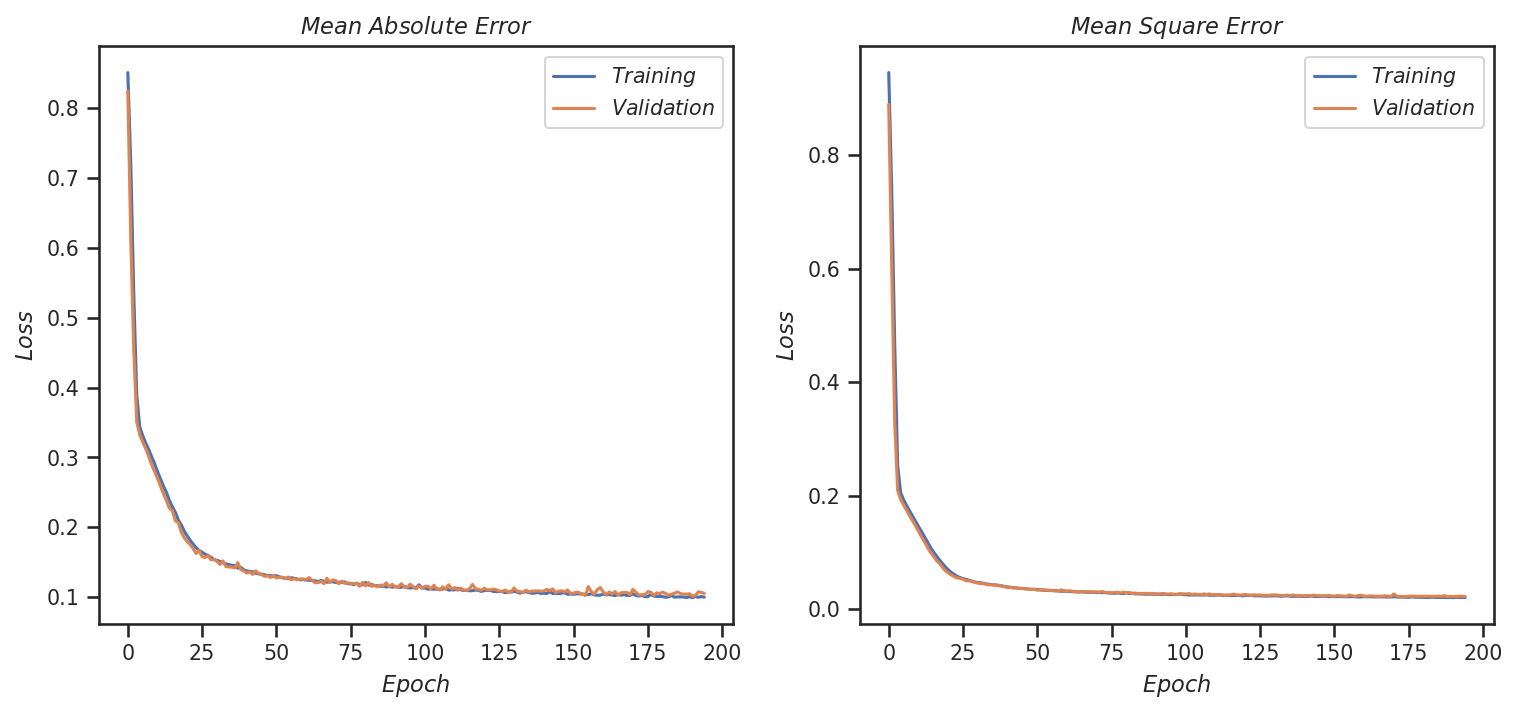

In [15]:
hist = pd.DataFrame(history.history)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))
hist['epoch'] = history.epoch


ax.set_xlabel(r'$Epoch$')
ax.set_ylabel(r'$Loss$')
ax.set_title(r'$Mean \ Absolute \  Error$')
ax.plot(hist['epoch'], hist['mae'], label='$Training$')
try:
    ax.plot(hist['epoch'], hist['val_mae'], label=r'$Validation$')
except KeyError:
    pass
# plt.ylim([0,5])
ax.legend()

ax1.set_xlabel(r'$Epoch$')
ax1.set_ylabel(r"$Loss$")
ax1.set_title(r'$Mean \ Square \ Error$')
ax1.plot(hist['epoch'], hist['mse'],
         label=r'$Training$')
try:
    ax1.plot(hist['epoch'], hist['val_mse'],
              label=r'$Validation$')
except KeyError:
    pass
# plt.ylim([0,3])
ax1.legend()
plt.savefig(f"{path}/images/loss.jpeg",  bbox_inches="tight")
plt.show()

We can use the `X_test` variable to predict the quantities after training our DNN.

In [16]:
# yhat = model.predict(X_test[:, :4])
yhat = model.predict(X_test[:, :3])

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


DNN input data is scaled. Therefore, we need to apply and inverse transformation

In [17]:
yhat = scaler_y.inverse_transform(yhat)

Similarly, data need to be inversely tranformed for the test dataset 

In [18]:
# y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 3:])

Let's define some figure settings such as colormaps.

In [19]:
n_c = 6
my_cmap6 = ListedColormap(sns.color_palette('deep', 6))
colors6 = my_cmap6(np.linspace(0,1,6))

We created a function for computing some model performance metrics

In [20]:
def metrics_pd(x, xpred):
    """
    Function that computes the Root Mean Square Error, the Mean Absolute Error 
    and the Correlation Coefficient between the 'True' parameter and the estimate parameter
    param x: True parameter values
    param xpred: Estimated parameter values
    """
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

Finally, scatter plots of true parameter values in the `x-axis` versus the estimate parametert in the `y-axis`

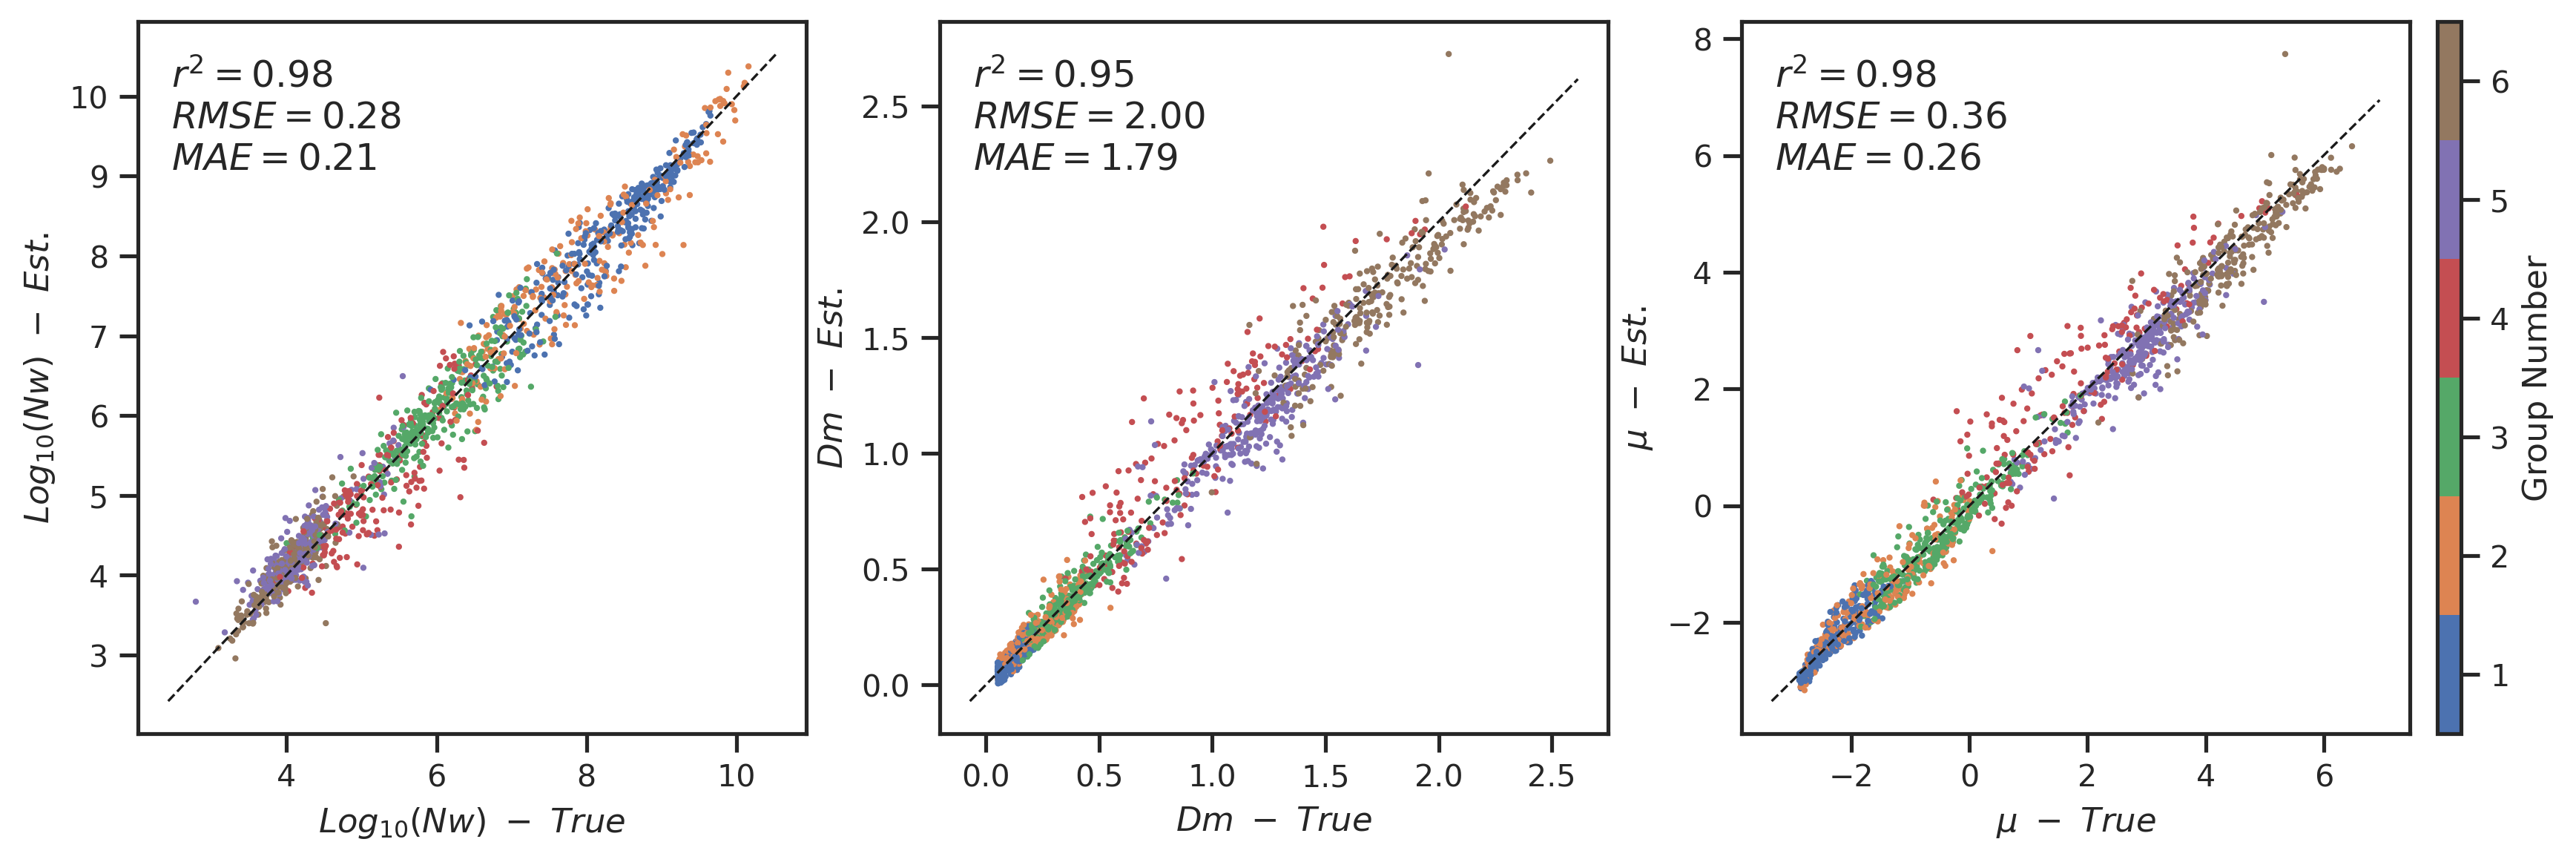

In [21]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4), dpi=300)
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

We can saved our model for further analysis. 

In [19]:
# model.save(f"../data/dnn_zku_Dfr_ka_16x6.keras")